In [1]:
!pip install onnx
!pip install onnxruntime-gpu
!pip install onnx-tf

     |████████████████████████████████| 12.7 MB 6.4 MB/s 
     |████████████████████████████████| 95.6 MB 1.2 MB/s 
     |████████████████████████████████| 222 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 


In [11]:
import os, sys, time, pprint
from argparse import Namespace
import numpy as np
from PIL import Image

import onnx
from onnx_tf.backend import prepare
from google.colab import drive
import tensorflow as tf

# from utils.common import tensor2im, log_input_image
# from models.psp import pSp

# %load_ext autoreload
# %autoreload 2

In [3]:

# Mount the root of your google drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
current_path_vasco = "/content/drive/My Drive/Colab Notebooks/MLOps CS215/StyleTransferProject/PSP/v3_pixel2style2pixel"

# Set current working directory
os.chdir(current_path_vasco)

In [10]:
!ls

cog.yaml	     LICENSE		psp_FFHQ_experiment_DY.ipynb
configs		     licenses		README.md
criteria	     models		scripts
datasets	     ninja-linux.zip	shape_predictor_68_face_landmarks.dat
docs		     notebooks		stylegan2directions
download-weights.sh  options		training
environment	     predict.py		utils
inversion_images     pretrained_models


In [73]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_preprocess_image_from_path(image_path):
    print("Image", image_path)

    image_width = 256
    image_height = 256
    num_channels = 3

    # Prepare the data
    # def load_image(path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height, image_width])
        # return image

    # Normalize pixels
    # def normalize(image):
    image = image / 256 # Scales from -1 to 1
        # return image


    # From (256, 256, 3) to (3, 256, 256)
    image = tf.transpose(image, [2,0,1])


    # image = tf.image.per_image_standardization(image)
    return image

    # test_data = tf.data.Dataset.from_tensor_slices(([image_path]))
    # test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
    # test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
    # test_data = test_data.repeat(1).batch(1)

    # return test_data

In [104]:
# image_path1 = './notebooks/images/Dongyun.jpg'
# original_image1 = Image.open(image_path1)
# original_image1 = original_image1.convert("RGB")
# original_image1.resize((256, 256))
# original_image1

image_path1 = './notebooks/images/Dongyun.jpg'
original_image1 = Image.open(image_path1)
original_image1 = original_image1.convert("RGB")
original_image1 = original_image1.resize((256, 256))

# float32 is required
img_arr = np.array(original_image1)

# https://stackoverflow.com/questions/67480507/tensorflow-equivalent-of-pytorchs-transforms-normalize
def normalize_image(image, mean, std):
    for channel in range(3):
        image[:,:,channel] = (image[:,:,channel] - mean[channel]) / std[channel]
    return image

img_resized = normalize_image(np.array(original_image1) / 255.0, 
                            mean=[0.5, 0.5, 0.5], 
                            std=[0.5, 0.5, 0.5])

# Move color axis to start like model is used to
img_resized = np.moveaxis(img_resized, 2, 0)


# Add in the first batch dim
input_batch_img = np.expand_dims(img_resized, axis=0)

tf_input = tf.convert_to_tensor(input_batch_img, dtype='float32')

print(tf_input.shape)

tf_input

(1, 3, 256, 256)


<tf.Tensor: shape=(1, 3, 256, 256), dtype=float32, numpy=
array([[[[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [0.6862745 , 0.60784316, 0.6       , ..., 0.6156863 ,
          0.78039217, 0.9137255 ],
         [0.6       , 0.5921569 , 0.5764706 , ..., 0.4509804 ,
          0.48235294, 0.5372549 ],
         [0.6156863 , 0.6156863 , 0.6784314 , ..., 0.46666667,
          0.49019608, 0.49019608]],

        [[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [0.7176471 , 0.647058

**Load psp model**

In [47]:
tic = time.time()

# Convert model to tensorflow
model_psp = onnx.load('../output/mnist.onnx')
tf_rep_psp = prepare(model_psp)

toc = time.time()
print('Loading and converting PSP onnx to tf took {:.4f} seconds.'.format(toc - tic))

Loading and converting PSP onnx to tf took 53.9822 seconds.


## Load the decoder model

In [153]:
tic = time.time()

# Convert model to tensorflow
model_dec = onnx.load('../output/decoder.onnx')
tf_rep_dec = prepare(model_dec)

toc = time.time()
print('Loading and converting Decoder onnx to tf took {:.4f} seconds.'.format(toc - tic))

Loading and converting Decoder onnx to tf took 8.8677 seconds.


In [105]:
# Now it has some errors...
# np_original_image = np.array(original_image)
# print(np_original_image.shape)

tic = time.time()
result_img_tf, result_vec_tf = tf_rep_psp.run(tf_input, randomize_noise=False, return_latents= True)
toc = time.time()
print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 75.9860 seconds.


In [109]:
result_img_tf

array([[[[0.96059275, 1.0207363 , 1.0117314 , ..., 1.01342   ,
          1.0100753 , 0.9532575 ],
         [1.0107385 , 0.99333984, 0.988482  , ..., 0.9887221 ,
          0.9890335 , 0.9891116 ],
         [1.00175   , 0.99726063, 0.99890125, ..., 0.99847794,
          0.99315023, 0.9908252 ],
         ...,
         [0.5099019 , 0.5749515 , 0.55180216, ..., 0.37701735,
          0.35636508, 0.35119098],
         [0.45796648, 0.49292308, 0.5102207 , ..., 0.34927827,
          0.3173733 , 0.32068264],
         [0.39720687, 0.42543232, 0.43641722, ..., 0.29173928,
          0.24571994, 0.21025372]],

        [[0.957051  , 1.019607  , 1.0052022 , ..., 1.001601  ,
          1.0020682 , 0.9745814 ],
         [1.0176078 , 0.9870616 , 0.98293775, ..., 0.9758599 ,
          0.9731925 , 0.99186873],
         [1.0082376 , 0.99224377, 0.9915259 , ..., 0.98552805,
          0.9778512 , 0.989045  ],
         ...,
         [0.59893394, 0.62224567, 0.5869071 , ..., 0.45015037,
          0.4735282 , 0.5

In [110]:
# I adjusted the default implementation of tensor2im to not use "to.device()", since it's in tf now
def tensor2imtf(image_tensor, imtype=np.uint8, normalize=True):
    # if isinstance(image_tensor, list):
    #     image_numpy = []
    #     for i in range(len(image_tensor)):
    #         image_numpy.append(tensor2im(image_tensor[i], imtype, normalize))
    #     return image_numpy
    image_numpy = image_tensor
    if normalize:
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0     
    image_numpy = np.clip(image_numpy, 0, 255)
    if image_numpy.shape[2] == 1 or image_numpy.shape[2] > 3:       
        image_numpy = image_numpy[:,:,0]
    return image_numpy.astype(imtype)

In [112]:
# input_vis_image1 = log_input_image(transformed_image1, opts)
output_image_tf = tensor2imtf(result_img_tf[0])

output_image_tf.shape
# result_image_pt

# # input_vis_image1 = log_input_image(transformed_image1, opts)
# output_image_tf2 = output_image_tf.copy()

# res_image_tf = Image.fromarray(output_image_tf2)
# res_image_tf


(256, 256, 3)

In [114]:
print(result_vec_tf.shape)
result_vec_tf

(1, 18, 512)


array([[[ -2.2192788 ,   3.581765  ,  -2.1499627 , ...,   1.6829897 ,
           3.3403916 ,  -3.1100893 ],
        [ -1.3942274 ,  -2.5233514 ,  -1.1194171 , ...,   2.255873  ,
          -0.37515885,  -1.366645  ],
        [  6.5282826 , -11.637289  ,  24.8482    , ...,   5.138483  ,
          -7.8314176 ,   2.9578853 ],
        ...,
        [ -1.1674731 ,  -0.32220924,  -0.96371406, ...,  -1.6783408 ,
           0.96989524,  -0.64624417],
        [  0.1575501 ,  -0.0368161 ,  -0.24273513, ...,  -0.31167674,
          -0.7992646 ,  -0.55975795],
        [ -0.7585723 ,  -0.5191512 ,  -0.46930254, ...,  -0.03575612,
          -0.28687134,  -0.45685148]]], dtype=float32)

In [116]:
empty_arr = np.ndarray(shape=(1, 18, 512))
empty_arr.shape

(1, 18, 512)

In [118]:
list_emtpy = empty_arr.tolist()
empty_reversed = np.array(list_emtpy)
empty_reversed.shape

(1, 18, 512)

In [126]:
from datetime import datetime
datetime.now().strftime('%d-%m-%Y_%H-%M')

'30-11-2021_22-57'

## Applying the latent manipulation

In [134]:
current_path = ''


age_vector_file = os.path.join(current_path, 'stylegan2directions/age.npy')
eye_distance_vector_file = os.path.join(current_path, 'stylegan2directions/eye_distance.npy')
eye_eyebrow_distance_vector_file = os.path.join(current_path, 'stylegan2directions/eye_eyebrow_distance.npy')
eye_ratio_vector_file = os.path.join(current_path, 'stylegan2directions/eye_ratio.npy')
# eyes_open_vector_file = os.path.join(current_path, 'stylegan2directions/eyes_open.npy')
gender_vector_file = os.path.join(current_path, 'stylegan2directions/gender.npy')
lip_ratio_vector_file = os.path.join(current_path, 'stylegan2directions/lip_ratio.npy')
mouth_open_vector_file = os.path.join(current_path, 'stylegan2directions/mouth_open.npy')
nose_mouth_distance_vector_file = os.path.join(current_path, 'stylegan2directions/nose_mouth_distance.npy')
nose_ratio_vector_file = os.path.join(current_path, 'stylegan2directions/nose_ratio.npy')
nose_tip_vector_file = os.path.join(current_path, 'stylegan2directions/nose_tip.npy')
pitch_vector_file = os.path.join(current_path, 'stylegan2directions/pitch.npy')
roll_vector_file = os.path.join(current_path, 'stylegan2directions/roll.npy')
smile_vector_file = os.path.join(current_path, 'stylegan2directions/smile.npy')
yaw_vector_file = os.path.join(current_path, 'stylegan2directions/yaw.npy')

# load .npy feature vectors
latent_vectors_dict = {
  "age_vector": np.load(age_vector_file),
  "eye_distance_vector": np.load(eye_distance_vector_file),
  "eye_eyebrow_distance_vector": np.load(eye_eyebrow_distance_vector_file),
  "eye_ratio_vector": np.load(eye_ratio_vector_file),
  # eyes_open_vector = np.load(eyes_open_vector_file),
  "gender_vector": np.load(gender_vector_file),
  "lip_ratio_vector": np.load(lip_ratio_vector_file),
  "mouth_open_vector": np.load(mouth_open_vector_file),
  "nose_mouth_distance_vector": np.load(nose_mouth_distance_vector_file),
  "nose_ratio_vector": np.load(nose_ratio_vector_file),
  "nose_tip_vector": np.load(nose_tip_vector_file),
  "pitch_vector": np.load(pitch_vector_file),
  "roll_vector": np.load(roll_vector_file),
  "smile_vector": np.load(smile_vector_file),
  "yaw_vector": np.load(yaw_vector_file),
}

In [150]:
def mutate_latent(input_latent, change_degrees_dict):
  # If nothing need to be changed we will return the input latent as is
  multiple_latent = input_latent

  for feat_vector_name, lat_feat_vector in latent_vectors_dict.items():
    feat_name = feat_vector_name[:feat_vector_name.index("_vector")]

    # Get the degree (int) of the amount we want this feature to be changed
    feat_change_degree = change_degrees_dict[f"{feat_name}_degree"]

    # 0 means nothing has been changed for this vector in terms of degree
    # So we can skip this specific manipulation
    if feat_change_degree == 0:
      print("Nope", feat_vector_name)
      continue

    # Update the latent with the right feature axis to change in the degree specified
    multiple_latent += (lat_feat_vector * feat_change_degree)
  
  return multiple_latent

  # # create combined vector
  # change_degrees_dict = np.float32(result_vec_tf + (age_vector * feature_dict['age_degree']) + (eye_distance_vector * feature_dict['eye_distance_degree']) 
  # + (eye_eyebrow_distance_vector * feature_dict['eye_eyebrow_distance_degree']) + (eye_ratio_vector * feature_dict['eye_ratio_degree']) + (gender_vector * feature_dict['gender_degree'])
  # + (lip_ratio_vector * feature_dict['lip_ratio_degree']) + (mouth_open_vector * feature_dict['mouth_open_degree']) + (nose_mouth_distance_vector * feature_dict['nose_mouth_distance_degree'])
  # + (nose_ratio_vector * feature_dict['nose_ratio_degree']) + (nose_tip_vector * feature_dict['nose_tip_degree']) + (pitch_vector * feature_dict['pitch_degree'])
  # + (roll_vector * feature_dict['roll_degree']) + (smile_vector * feature_dict['smile_degree']) + (yaw_vector * feature_dict['yaw_degree']) + (eyes_open_vector * feature_dict['eyes_open_degree'])
  # )





In [160]:
feature_dict = {'age_degree': 8, 'eye_distance_degree': 0, 'eye_eyebrow_distance_degree': 0, 'eye_ratio_degree': 0,  'eyes_open_degree': 0,
                'gender_degree': 1, 'lip_ratio_degree': 0, 'mouth_open_degree': 0, 'nose_mouth_distance_degree': 0, 'nose_ratio_degree': 0,
                'nose_tip_degree': 0, 'pitch_degree': 0, 'roll_degree': 0, 'smile_degree': 0, 'yaw_degree': 0}

matched_latent = np.ndarray(shape=(1, 18, 512))

new_latent = mutate_latent(result_vec_tf, feature_dict)
new_latent

Nope eye_distance_vector
Nope eye_eyebrow_distance_vector
Nope eye_ratio_vector
Nope lip_ratio_vector
Nope mouth_open_vector
Nope nose_mouth_distance_vector
Nope nose_ratio_vector
Nope nose_tip_vector
Nope pitch_vector
Nope roll_vector
Nope smile_vector
Nope yaw_vector


array([[[-2.1402717e+00,  3.6940277e+00, -2.7042916e+00, ...,
          1.5293344e+00,  3.6320040e+00, -3.0333636e+00],
        [-1.3152207e+00, -2.4110887e+00, -1.6737458e+00, ...,
          2.1022177e+00, -8.3546460e-02, -1.2899191e+00],
        [ 6.6072893e+00, -1.1525027e+01,  2.4293869e+01, ...,
          4.9848289e+00, -7.5398049e+00,  3.0346110e+00],
        ...,
        [-1.0884664e+00, -2.0994645e-01, -1.5180428e+00, ...,
         -1.8319961e+00,  1.2615076e+00, -5.6951827e-01],
        [ 2.3655690e-01,  7.5446688e-02, -7.9706389e-01, ...,
         -4.6533200e-01, -5.0765222e-01, -4.8303205e-01],
        [-6.7956537e-01, -4.0688843e-01, -1.0236312e+00, ...,
         -1.8941134e-01,  4.7410377e-03, -3.8012555e-01]]], dtype=float32)

Text(0.5, 1.0, 'Original Image')

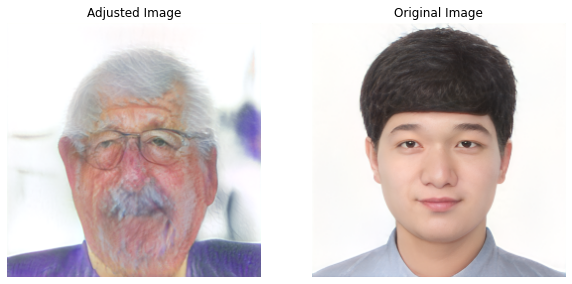

In [161]:
import matplotlib.pyplot as plt

# Run model
reulst_img = tf_rep_dec.run([new_latent], input_is_latent=True, randomize_noise=False, return_latents=False)[0]

%matplotlib inline

reulst_img_tf = tensor2imtf(reulst_img[0])
result = Image.fromarray(reulst_img_tf)
result = result.resize((256, 256))


fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)

ax1.imshow(result)
ax1.axis('off')
ax1.set_title('Adjusted Image')



original = Image.fromarray(output_image_tf2)
original = original.resize((256, 256))

ax2 = fig.add_subplot(1, 2, 2)

ax2.imshow(original)
ax2.axis('off')
ax2.set_title('Original Image')